<a href="https://colab.research.google.com/github/anurag160304/Rain-Prediction-Model/blob/main/Rainfall_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
full_data = pd.read_csv('weatherAUS.csv')


In [ ]:
full_data.shape

(21305, 24)

In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21305 entries, 0 to 21304
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           21305 non-null  object 
 1   Location       21305 non-null  object 
 2   MinTemp        20982 non-null  float64
 3   MaxTemp        21129 non-null  float64
 4   Rainfall       21083 non-null  float64
 5   Evaporation    7360 non-null   float64
 6   Sunshine       4778 non-null   float64
 7   WindGustDir    17893 non-null  object 
 8   WindGustSpeed  17895 non-null  float64
 9   WindDir9am     18515 non-null  object 
 10  WindDir3pm     19609 non-null  object 
 11  WindSpeed9am   20762 non-null  float64
 12  WindSpeed3pm   20088 non-null  float64
 13  Humidity9am    20949 non-null  float64
 14  Humidity3pm    20259 non-null  float64
 15  Pressure9am    17901 non-null  float64
 16  Pressure3pm    17898 non-null  float64
 17  Cloud9am       11919 non-null  float64
 18  Cloud3

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

/tmp/ipython-input-6-1005310116.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
/tmp/ipython-input-6-1005310116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True

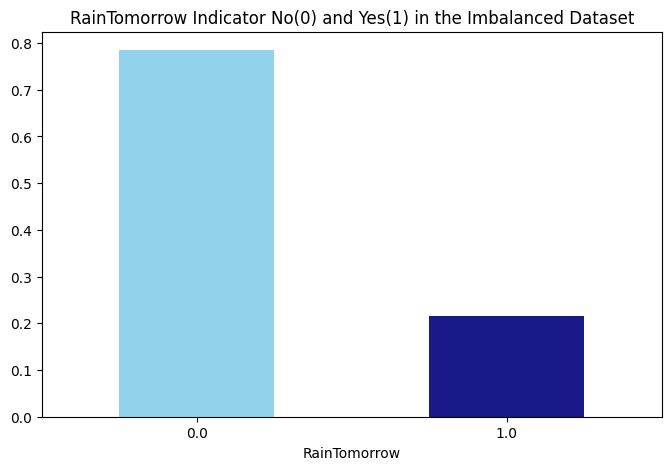

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

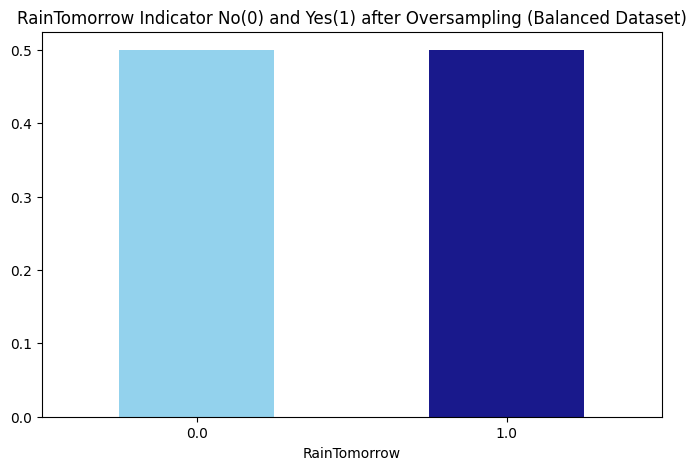

In [ ]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<Axes: >

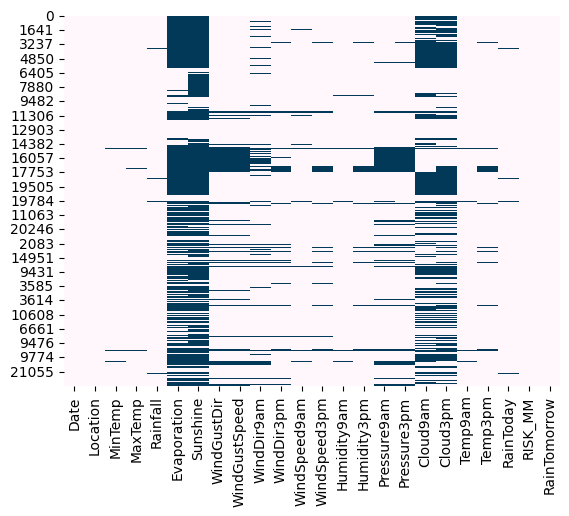

In [ ]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

Total   Percent
Sunshine     25898  0.774230
Evaporation  22380  0.669058
Cloud3pm     14657  0.438176
Cloud9am     14190  0.424215

In [ ]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1568.000000
Location            4.000000
MinTemp             8.800000
MaxTemp             8.500000
Rainfall            2.600000
Evaporation         4.049276
Sunshine            5.740314
WindGustDir         7.000000
WindGustSpeed      17.507395
WindDir9am          8.000000
WindDir3pm          7.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        33.000000
Pressure9am         7.200000
Pressure3pm         7.200000
Cloud9am            4.035240
Cloud3pm            3.692698
Temp9am             7.800000
Temp3pm             8.100000
RainToday           1.000000
RISK_MM             6.200000
RainTomorrow        1.000000
dtype: float64


In [ ]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(23218, 24)

<Axes: >

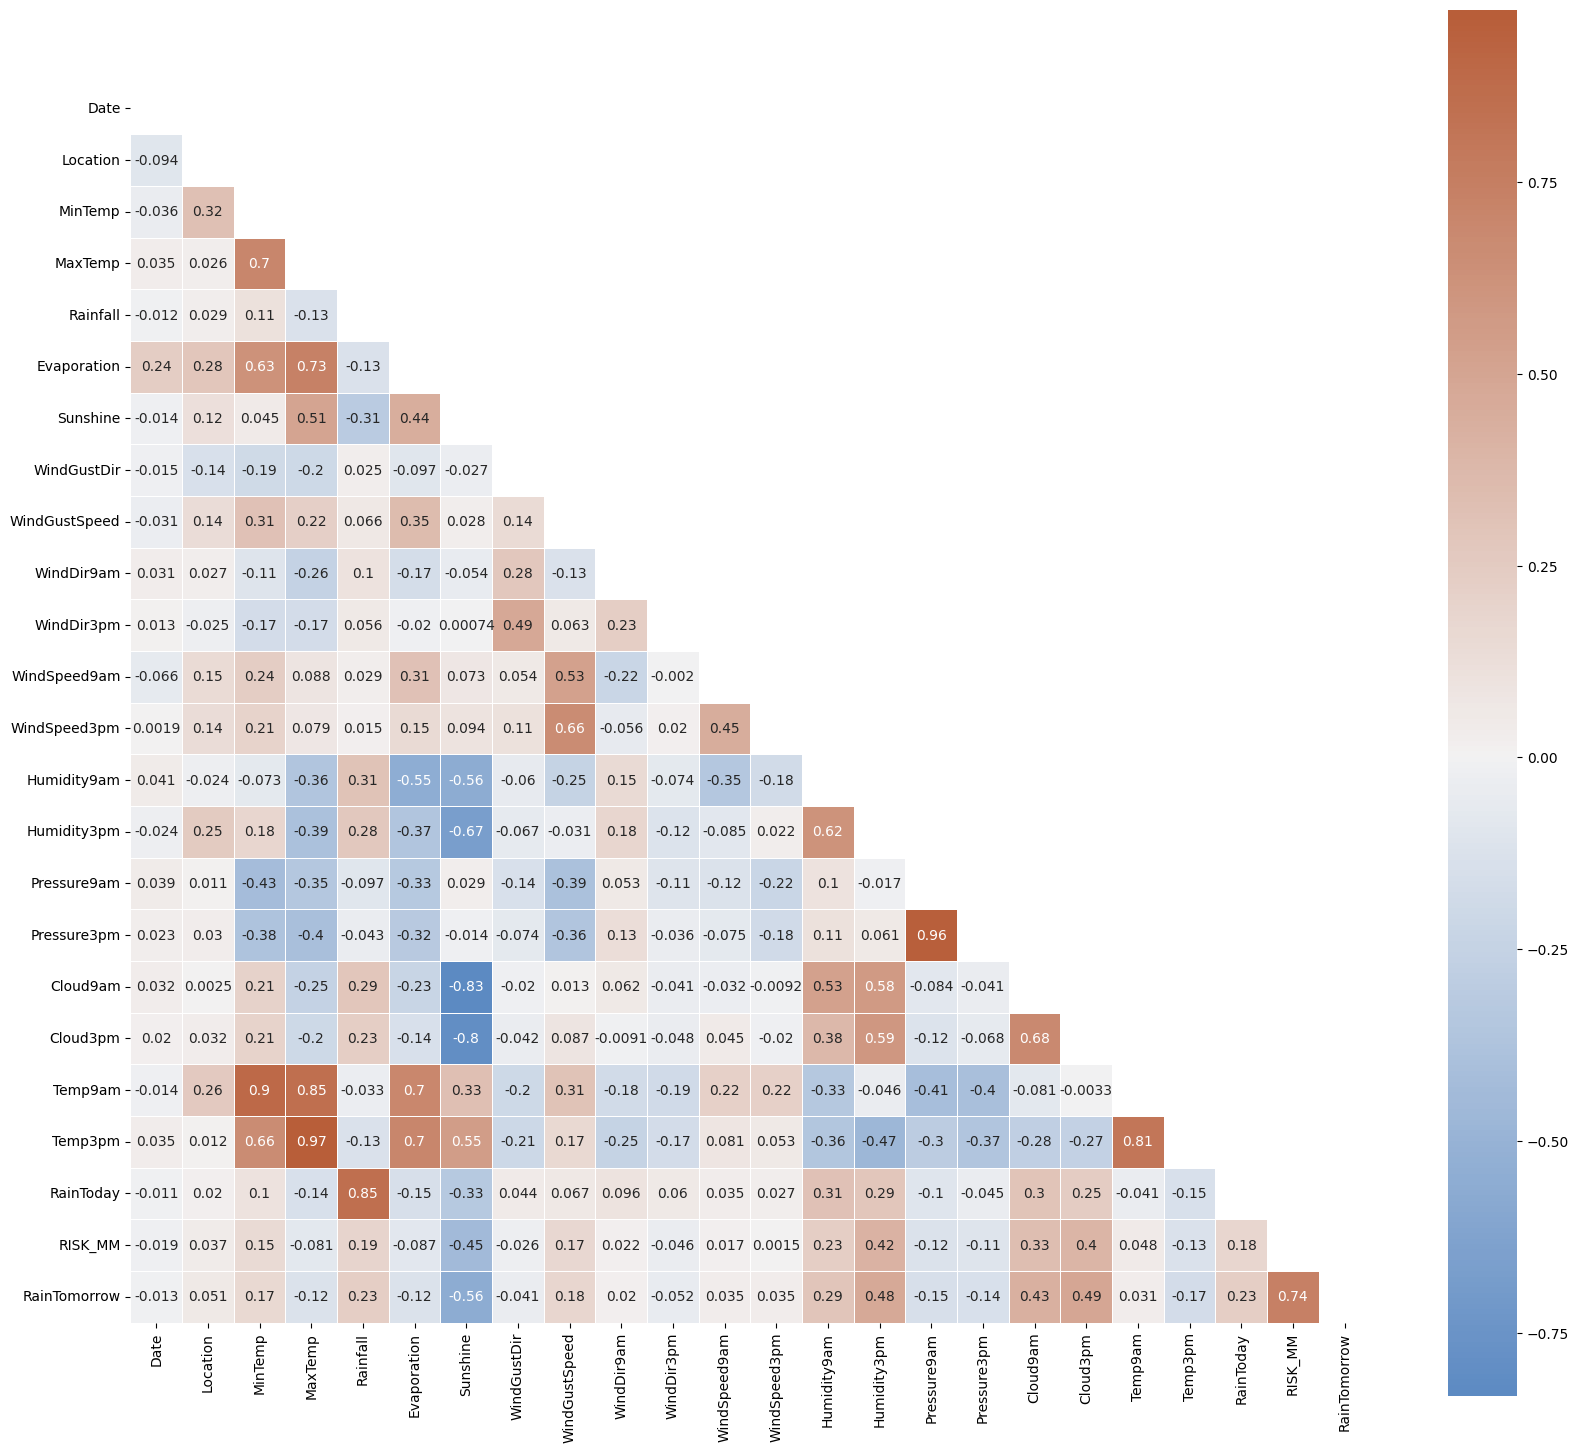

In [ ]:
#Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

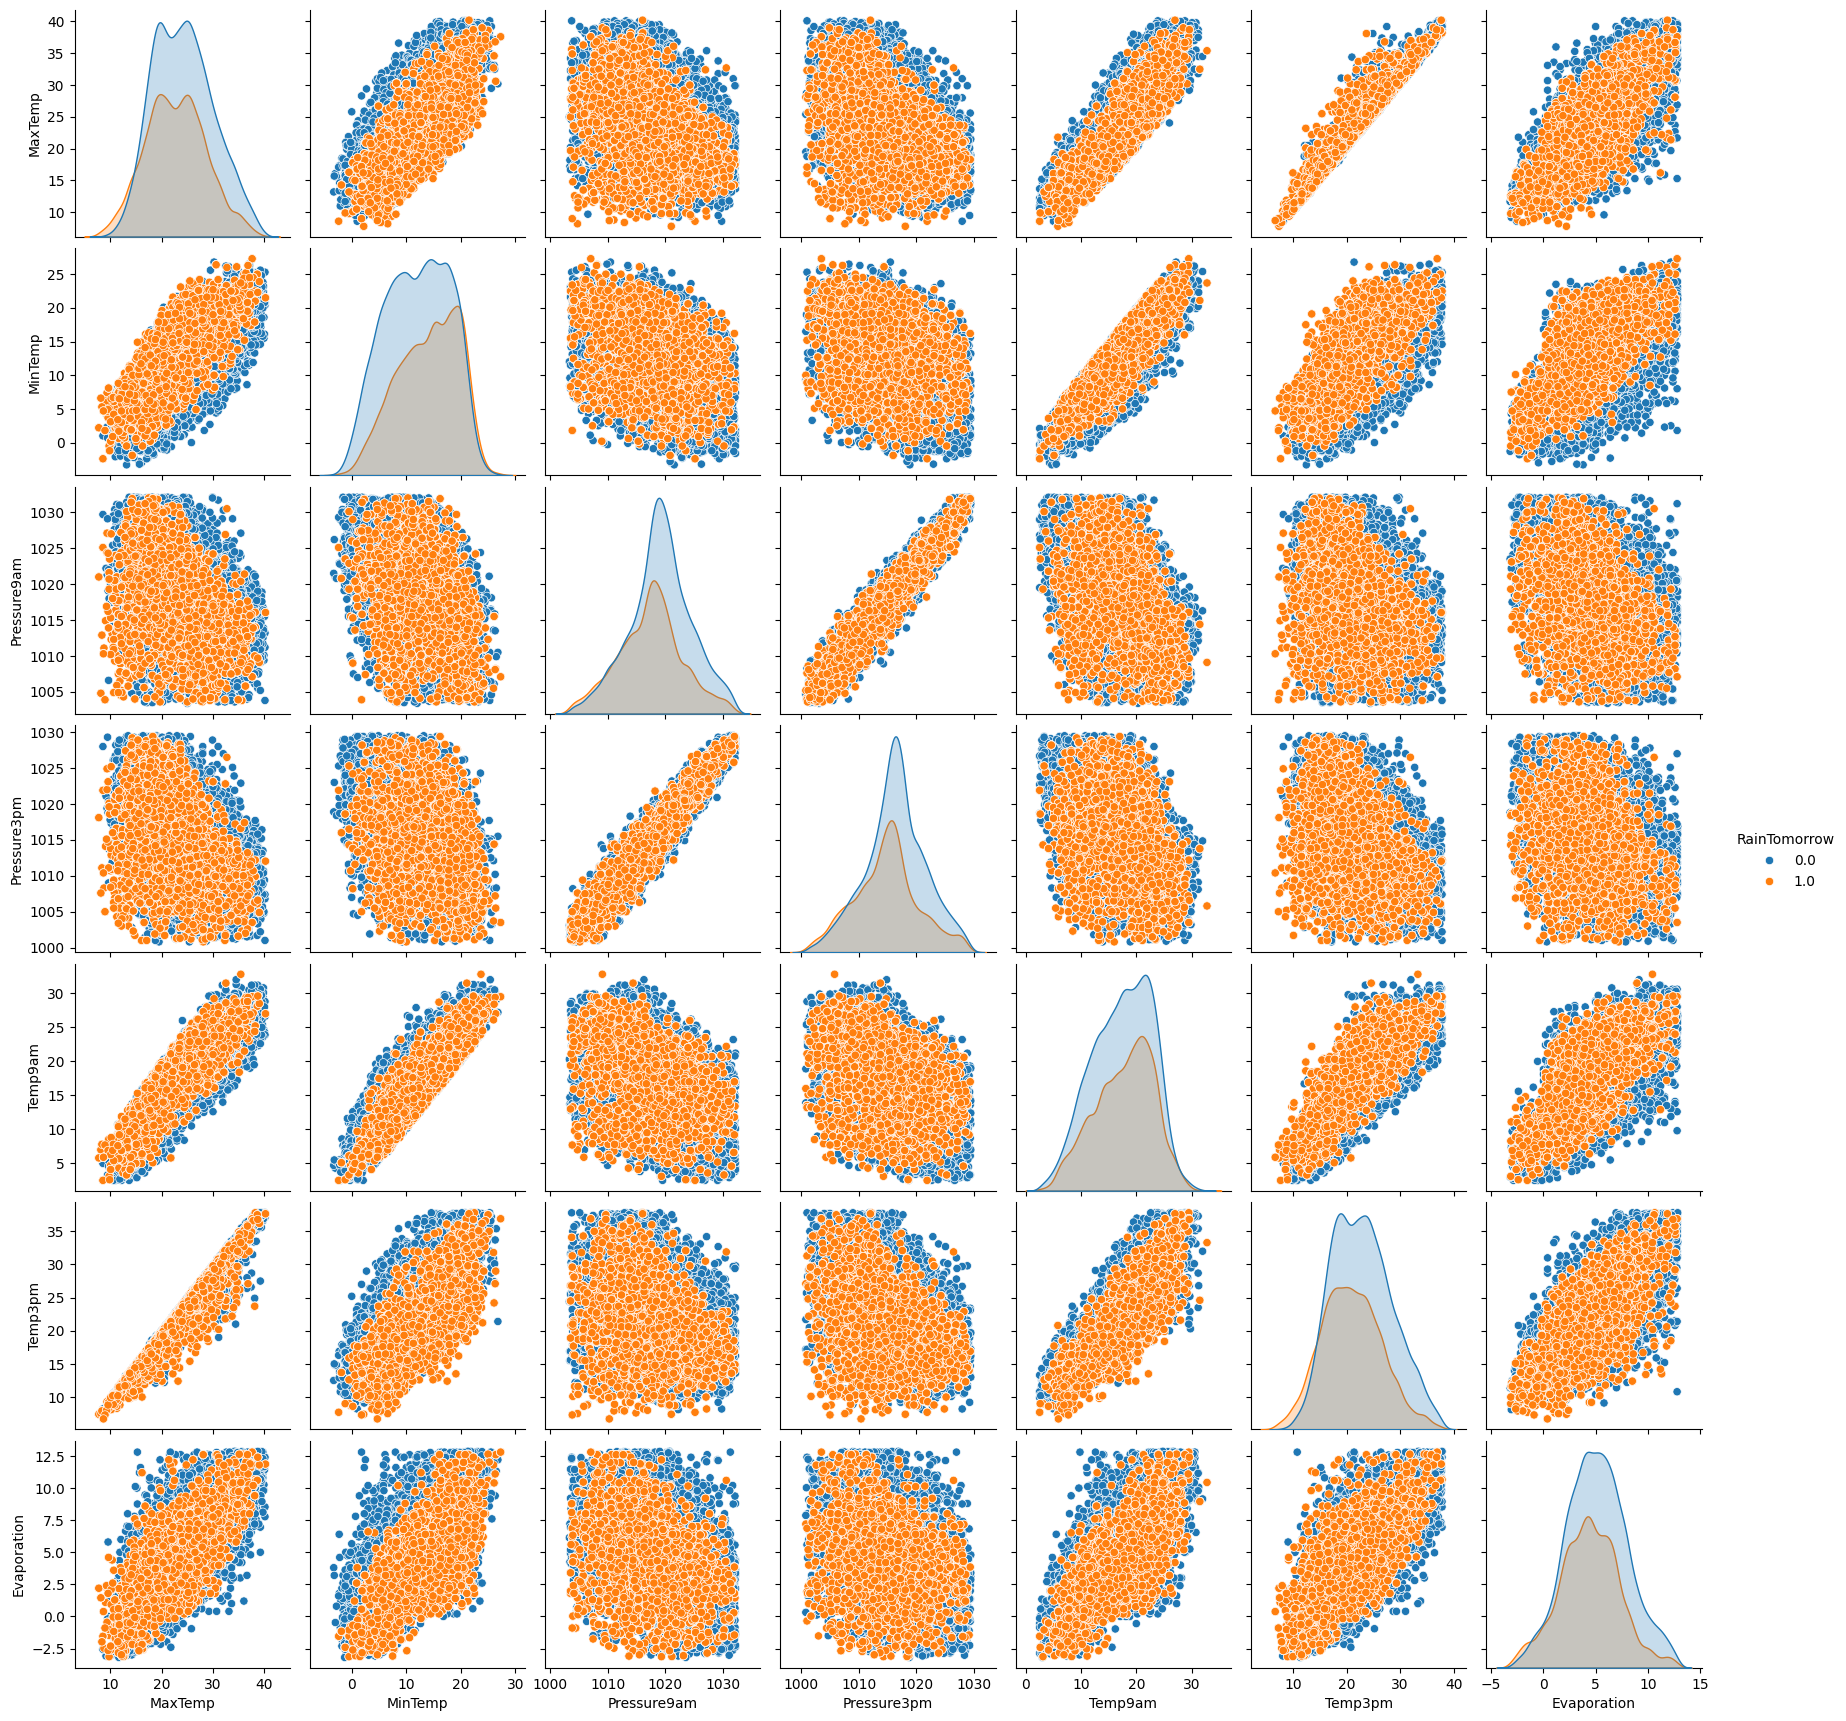

In [ ]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [ ]:
# Feature Selection for Rainfall Prediction
# I will use both the filter method and the wrapper method for feature selection to train our rainfall prediction model.

# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [ ]:
# Selection of features by wrapping method (random forest):
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00413824 0.00339335 0.00581984 0.00523092 0.00715663 0.003942
 0.09159028 0.00320698 0.01134425 0.00263778 0.00380279 0.00279194
 0.00389331 0.01516933 0.03655451 0.00634144 0.00762736 0.02870647
 0.05635603 0.00498603 0.00572121 0.0034608  0.68612852]


In [ ]:
# Training Rainfall Prediction Model with Different Models

In [ ]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, ConfusionMatrixDisplay
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')

    return model, accuracy, roc_auc, coh_kap, time_taken

FOR LOGISTIC REGRESSION
Accuracy = 0.8575366063738157
ROC Area under Curve = 0.8433260390861891
Cohen's Kappa = 0.6957373819586328
Time taken = 0.3517594337463379
              precision    recall  f1-score   support

         0.0    0.86740   0.90615   0.88635      3559
         1.0    0.83996   0.78050   0.80914      2246

    accuracy                        0.85754      5805
   macro avg    0.85368   0.84333   0.84775      5805
weighted avg    0.85679   0.85754   0.85648      5805



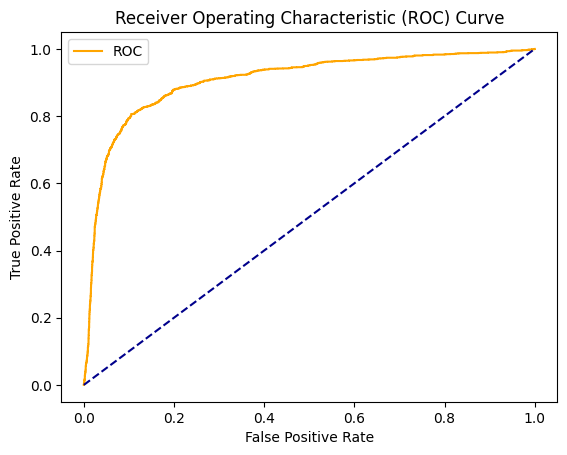

FOR DECICSION TREE
Accuracy = 0.9009474590869939
ROC Area under Curve = 0.9047641625447831
Cohen's Kappa = 0.7949686443228174
Time taken = 0.05517220497131348
              precision    recall  f1-score   support

         0.0    0.94724   0.88789   0.91661      3559
         1.0    0.83840   0.92164   0.87805      2246

    accuracy                        0.90095      5805
   macro avg    0.89282   0.90476   0.89733      5805
weighted avg    0.90513   0.90095   0.90169      5805



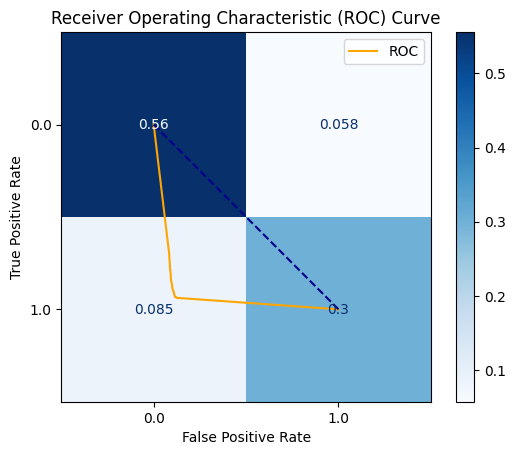

FOR NEURAL NETWORK
Accuracy = 0.9731266149870801
ROC Area under Curve = 0.977180311437498
Cohen's Kappa = 0.9439719309013133
Time taken = 61.21044969558716
              precision    recall  f1-score   support

         0.0    0.99679   0.95926   0.97766      3559
         1.0    0.93908   0.99510   0.96628      2246

    accuracy                        0.97313      5805
   macro avg    0.96793   0.97718   0.97197      5805
weighted avg    0.97446   0.97313   0.97326      5805



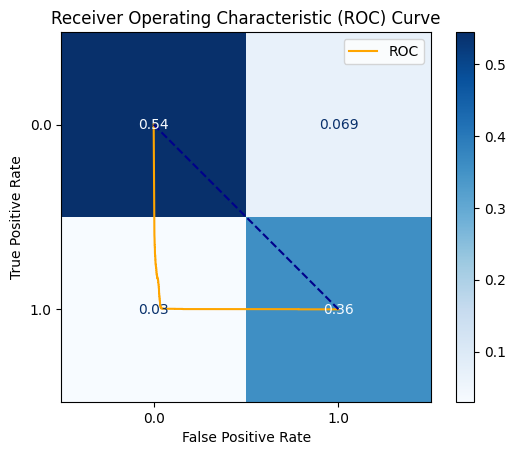

FOR RANDOM FOREST
Accuracy = 0.9593453919035314
ROC Area under Curve = 0.9614240995887416
Cohen's Kappa = 0.9150325175922469
Time taken = 3.714611291885376
              precision    recall  f1-score   support

         0.0    0.98090   0.95223   0.96635      3559
         1.0    0.92766   0.97061   0.94865      2246

    accuracy                        0.95935      5805
   macro avg    0.95428   0.96142   0.95750      5805
weighted avg    0.96030   0.95935   0.95950      5805



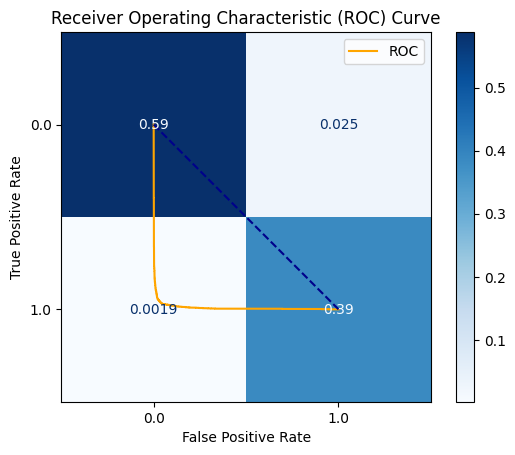

[LightGBM] [Info] Number of positive: 6852, number of negative: 10561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 17413, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393499 -> initscore=-0.432627
[LightGBM] [Info] Start training from score -0.432627
Accuracy = 0.9510766580534022
ROC Area under Curve = 0.9527095342548972
Cohen's Kappa = 0.8977509957466022
Time taken = 2.3162436485290527
              precision    recall  f1-score   support

         0.0    0.97395   0.94549   0.95951      3559
         1.0    0.91745   0.95993   0.93821      2246

    accuracy                        0.95108      5805
   macro avg    0.94570   0.95271   0.94886      5805
weighted avg    0.95209   0.9510

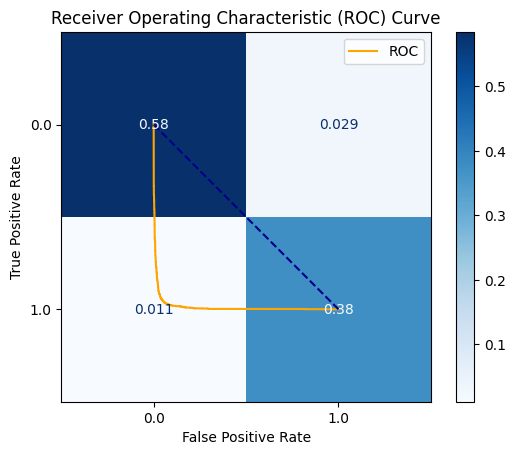

FOR CATBOOST
Accuracy = 0.9565891472868217
ROC Area under Curve = 0.9604903425452185
Cohen's Kappa = 0.9096252679067209
Time taken = 194.435866355896
              precision    recall  f1-score   support

         0.0    0.98532   0.94324   0.96382      3559
         1.0    0.91576   0.97774   0.94574      2246

    accuracy                        0.95659      5805
   macro avg    0.95054   0.96049   0.95478      5805
weighted avg    0.95841   0.95659   0.95683      5805



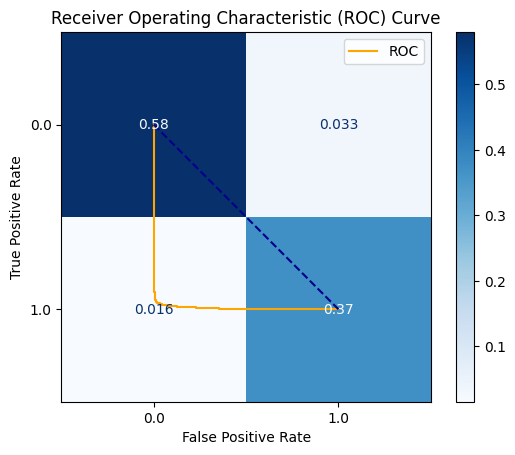

FOR XGBOOST
Accuracy = 0.9695090439276486
ROC Area under Curve = 0.9716019137515742
Cohen's Kappa = 0.9362068544826375
Time taken = 3.7301690578460693
              precision    recall  f1-score   support

         0.0    0.98760   0.96235   0.97481      3559
         1.0    0.94266   0.98085   0.96138      2246

    accuracy                        0.96951      5805
   macro avg    0.96513   0.97160   0.96810      5805
weighted avg    0.97021   0.96951   0.96961      5805



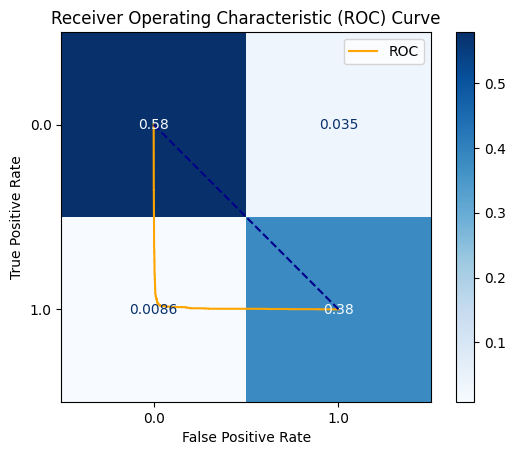

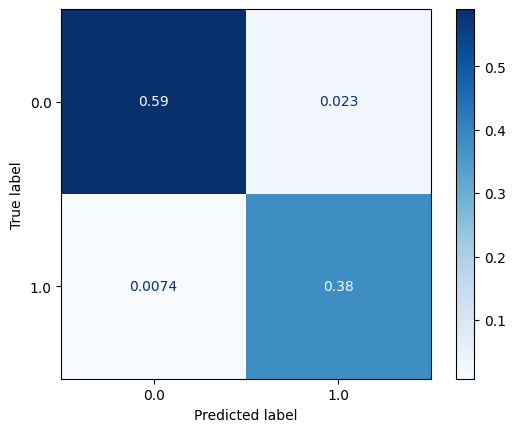

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
print("FOR LOGISTIC REGRESSION")
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
print("FOR DECICSION TREE")
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
print("FOR NEURAL NETWORK")
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
print("FOR RANDOM FOREST")
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95,
         'max_depth': 16,
         'min_split_gain': 0.1,
         'n_estimators': 200,
         'num_leaves': 50,
         'reg_alpha': 1.2,
         'reg_lambda': 1.2,
         'subsample': 0.95,
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)

model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
print("FOR CATBOOST")
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
print("FOR XGBOOST")
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

In [ ]:
# Plotting Decision Region for all Models

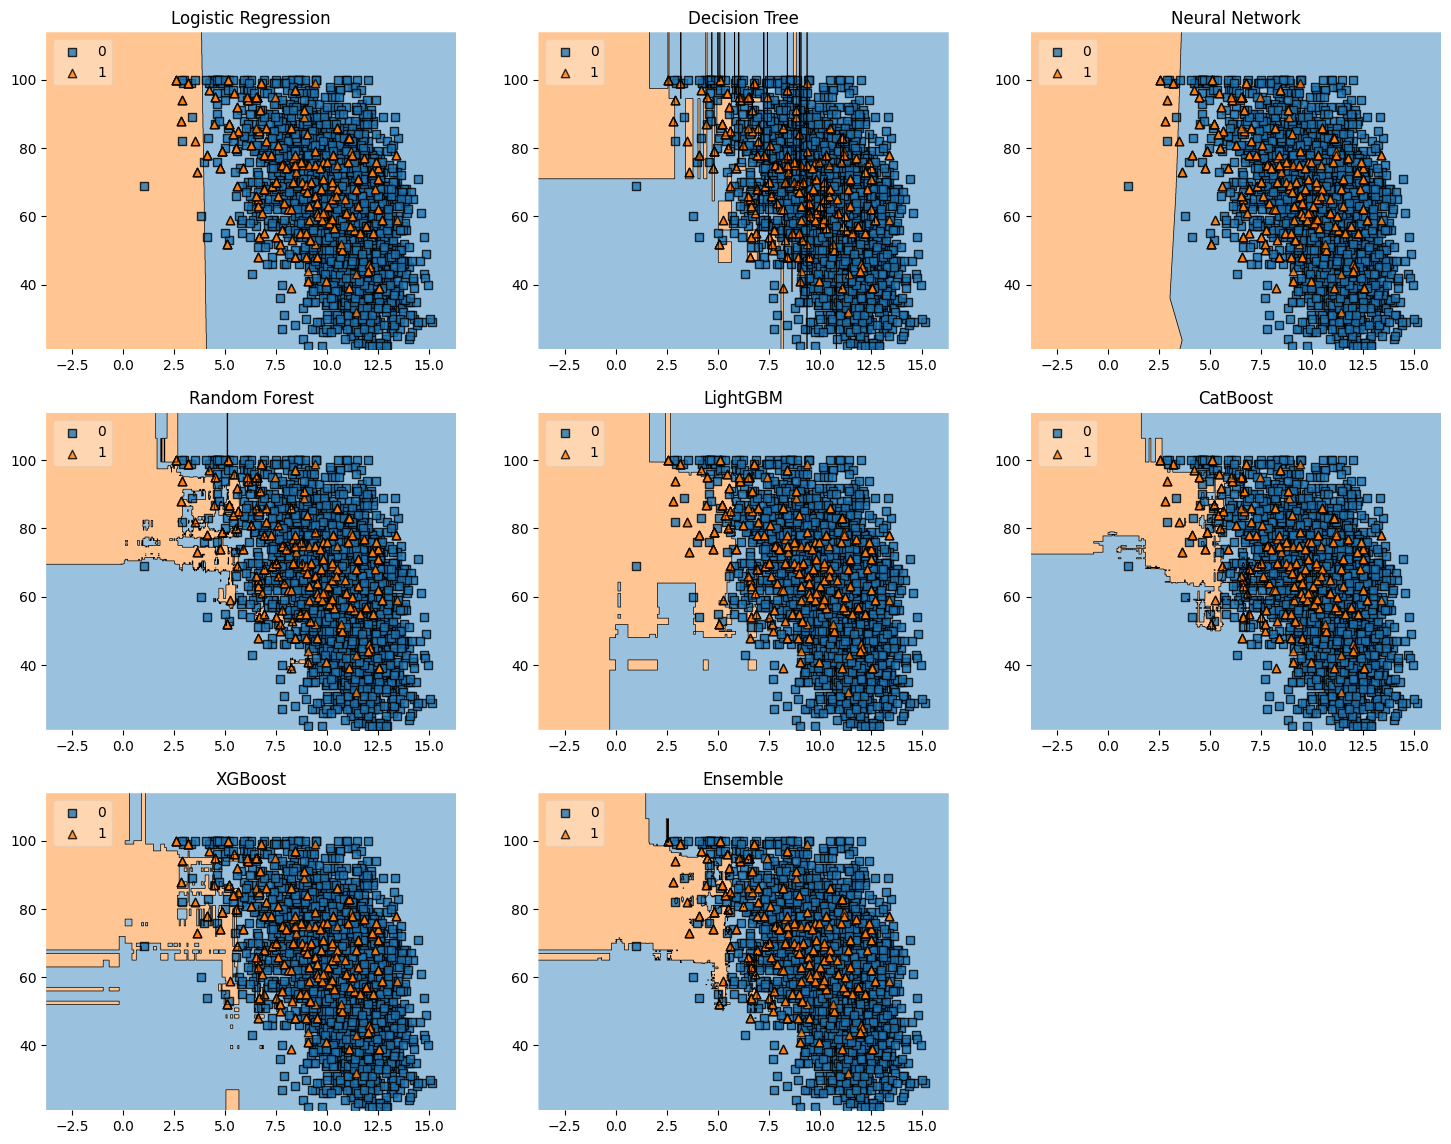

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345)
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf,
                                filler_feature_values={2: value},
                                filler_feature_ranges={2: width},
                                legend=2)
    plt.title(lab)

plt.show()

In [ ]:
#Rainfall Prediction Model Comparison
# Now we need to decide which model performed best based on Precision Score, ROC_AUC, Cohen’s Kappa and Total Run Time.
# For a better decision, we chose “Cohen’s Kappa” which is actually an ideal choice as a metric to decide on the best model in case of unbalanced datasets.

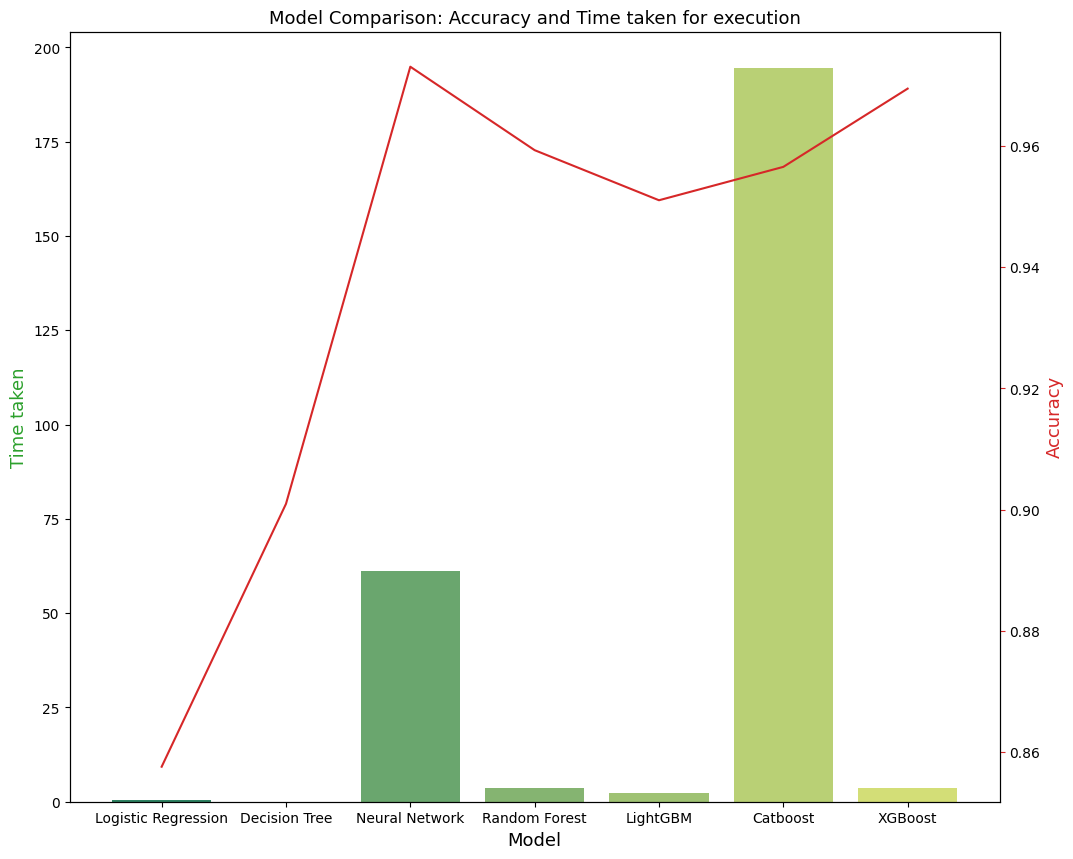

In [ ]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

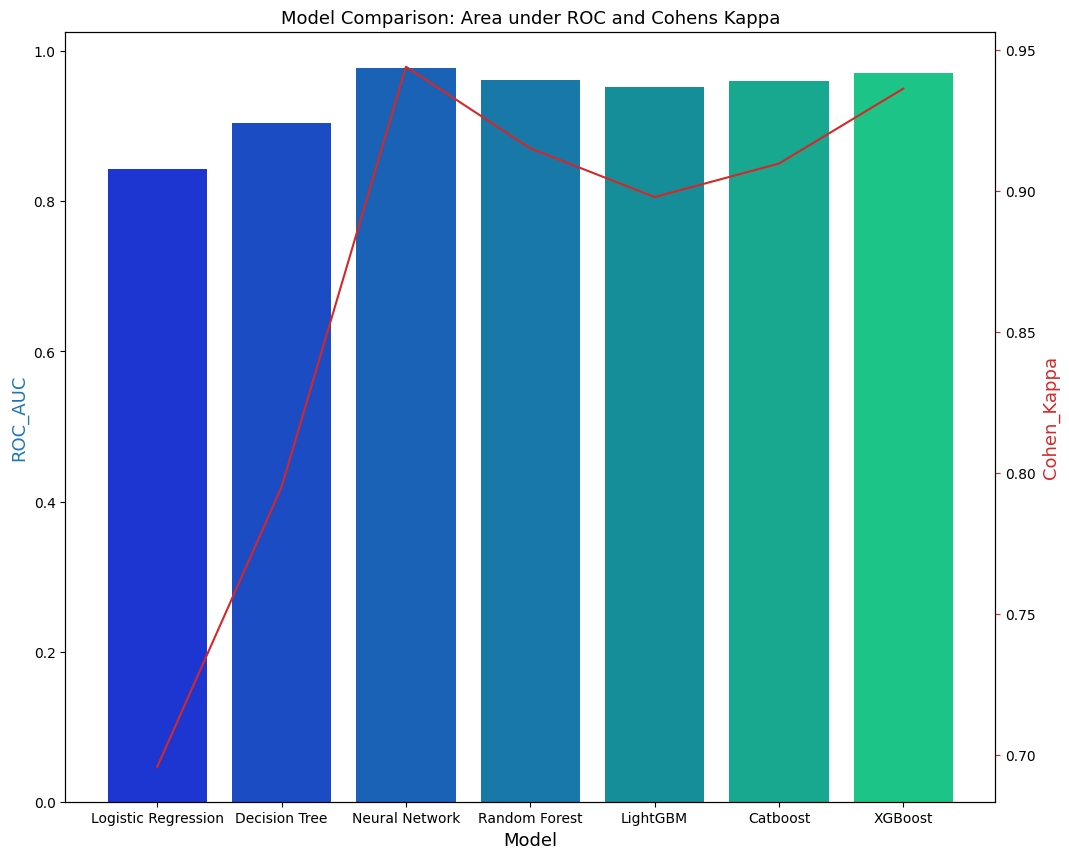

In [ ]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

In [ ]:
# We Can Observe that Neural Network, XGBoost,CatBoost performed better compared to other models
# However, if speed is an important thing to consider, we can stick with Neural Network instead of XGBoost or CatBoost.